### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 6th at 11.59pm CT
---

## Only one problem this week

1. Use the following code snippet to read in SDSS galaxy color data.
<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

In [94]:
# Import
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from astroML.classification import GMMBayes
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

Part 1

In [79]:
def process_data():
    # Read in SDSS galaxy color data
    data = np.load("../../homeworks/hw_data/hw8_data_1.npy")

    # print all of the column names
    print('column names: ',data.dtype)

    # create arrays of (𝑢−𝑔), (𝑔−𝑟), (𝑟−𝑖), and (𝑖−𝑧) colors
    u_g = data['u']-data['g']
    g_r = data['g']-data['r']
    r_i = data['r']-data['i']
    i_z = data['i']-data['z']
    # create arrays of redshift and the spectral class
    redshift = data['redshift']
    spec_class = data['specClass']

    # How many regular galaxies and how many quasars are in this sample?
    print('\nnumber of quasars = ',len(np.where(spec_class=='QSO')[0]))
    print('number of galaxies = ',len(np.where(spec_class=='GALAXY')[0]))

    return spec_class, u_g, g_r, r_i, i_z , redshift, spec_class

# Call the function
spec_class, u_g, g_r, r_i, i_z,redshift, spec_class = process_data()

column names:  [('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('specClass', '<U6'), ('redshift', '<f8'), ('redshift_err', '<f8')]

number of quasars =  7192
number of galaxies =  42808


part 2

/var/folders/m7/wmqknjsx4bj5g3v66n2dbjvr0000gr/T/ipykernel_80714/1744627871.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.scatter(u_g, g_r, c=class_labels, cmap=plt.cm.get_cmap('viridis', 2), alpha=0.5)


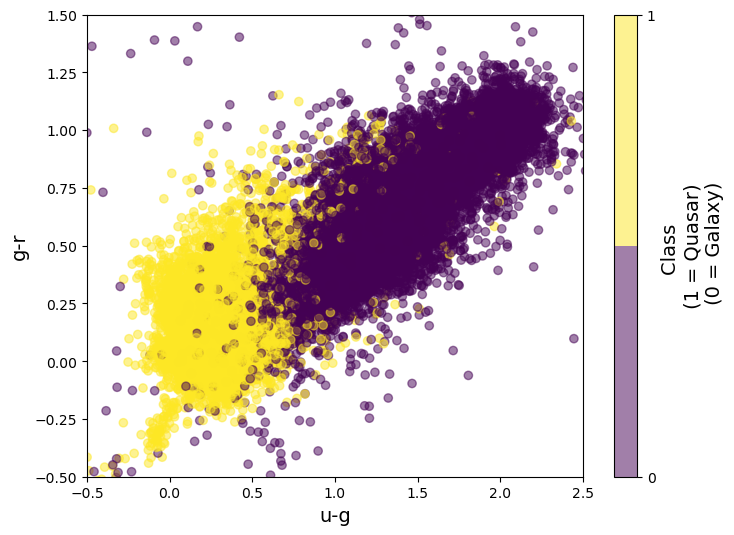

In [81]:
def plot_data(spec_class, u_g, g_r):
    # Define labels for color coding galaxy & quasar class
    class_labels = np.full(len(spec_class), 0)
    quasar_idx, galaxy_idx = np.where(spec_class=='QSO')[0], np.where(spec_class=='GALAXY')[0]
    class_labels[quasar_idx] = 1
    class_labels[galaxy_idx] = 0

    # Make a scatter plot of (𝑢−𝑔) versus (𝑔−𝑟)
    # Color code points by class
    fig, ax = plt.subplots(figsize=(8,6))
    im = ax.scatter(u_g, g_r, c=class_labels, cmap=plt.cm.get_cmap('viridis', 2), alpha=0.5)
    ax.set_xlabel('u-g',fontsize=14); ax.set_ylabel('g-r',fontsize=14)
    ax.set_xlim(-0.5,2.5); ax.set_ylim(-0.5,1.5)
    cbar = fig.colorbar(im,ticks=[0, 1])
    cbar.set_label('Class \n (1 = Quasar) \n (0 = Galaxy)', rotation=90, fontsize=14) 
    plt.show()

    return spec_class, u_g, g_r, class_labels

# Call the function with your data
spec_class, u_g, g_r, class_labels = plot_data(spec_class, u_g, g_r)

part 3

In [85]:
def split_dataset(features, labels, test_ratio=0.2):
    # Stack all features into a data matrix
    data_matrix = np.array(features).T
    print('Shape of data matrix:', np.shape(data_matrix))

    # Perform a train-test split, taking 20% of the data for testing by default
    train_data, test_data, train_labels, test_labels = train_test_split(data_matrix, labels, test_size=test_ratio)
    
    return data_matrix, train_data, test_data, train_labels, test_labels

# Call the function with your data
features = [u_g, g_r, r_i, i_z, redshift]
data_matrix, train_data, test_data, train_labels, test_labels = split_dataset(features, labels)

Shape of data matrix: (50000, 5)


Part 4

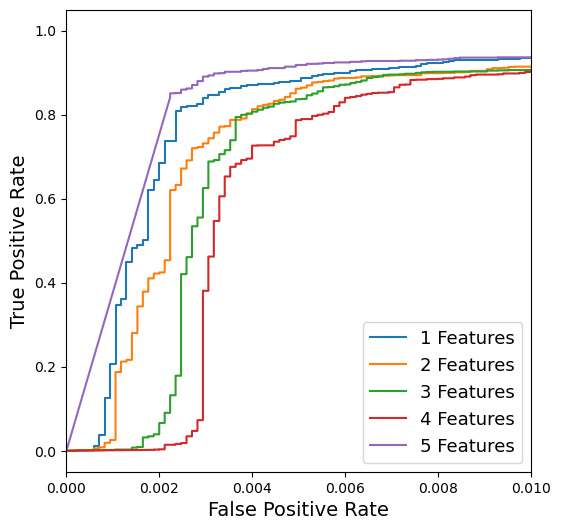

In [109]:
def perform_classification(train_data, train_labels, test_data, test_labels):
    num_features = np.shape(train_data)[1]
    
    # Preallocate lists
    fprs, tprs = [None]*num_features, [None]*num_features
    
    # Fit GNB classifier for each number of features and compute ROC curve
    for i in range(num_features):
        gnb_classifier = GaussianNB()
        gnb_classifier.fit(train_data[:,:i+1], train_labels)
        y_prob = gnb_classifier.predict_proba(test_data[:,:i+1])
        fprs[i], tprs[i], _ = roc_curve(test_labels, y_prob[:,1])

    # Plot ROC curves
    fig, ax = plt.subplots(figsize=(6,6))
    [ax.plot(fprs[j], tprs[j], label=f'{j+1} Features') for j in range(num_features)]
    ax.set_xlim(0,0.01)
    ax.set_xlabel('False Positive Rate',fontsize=14)
    ax.set_ylabel('True Positive Rate',fontsize=14)
    plt.legend(fontsize=13)
    plt.show()

# Call the function with your data
perform_classification(train_data, train_labels, test_data, test_labels)

SRT: Good, Kamara!

part 5

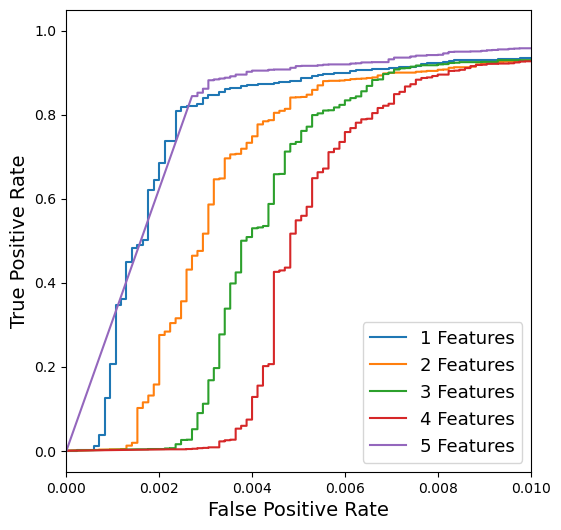

In [110]:
def perform_qda_classification(train_data, train_labels, test_data, test_labels):
    num_features = np.shape(train_data)[1]
    
    # Preallocate lists
    fprs, tprs = [None]*num_features, [None]*num_features
    
    # Fit QDA classifier for each number of features and compute ROC curve
    for i in range(num_features):
        qda_classifier = QDA()
        qda_classifier.fit(train_data[:,:i+1], train_labels)
        y_prob = qda_classifier.predict_proba(test_data[:,:i+1])
        fprs[i], tprs[i], _ = roc_curve(test_labels, y_prob[:,1])

    # Plot ROC curves
    fig, ax = plt.subplots(figsize=(6,6))
    [ax.plot(fprs[j], tprs[j], label=f'{j+1} Features') for j in range(num_features)]
    ax.set_xlim(0,0.01)
    ax.set_xlabel('False Positive Rate',fontsize=14)
    ax.set_ylabel('True Positive Rate',fontsize=14)
    plt.legend(fontsize=13)
    plt.show()

# Call the function with your data
perform_qda_classification(train_data, train_labels, test_data, test_labels)

part 6

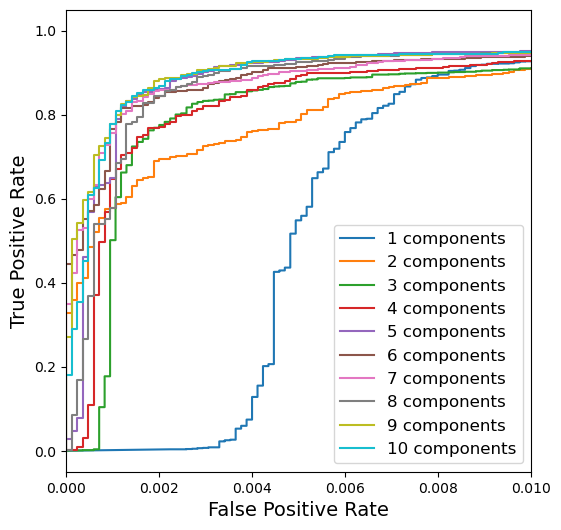

8 components gives the best performance.


In [111]:
def perform_gmmb_classification(train_data, train_labels, test_data, test_labels):
    # Define the number of components for GMMB classifier
    num_components = 10
    
    # Preallocate lists to store false positive rates, true positive rates, and area under ROC curve
    fprs, tprs, area = [None]*num_components, [None]*num_components, [None]*num_components
    
    # Loop over each number of components
    for i in range(num_components):
        # Initialize and fit a GMMB classifier with i+1 components
        gmmb_classifier = GMMBayes(i+1) 
        gmmb_classifier.fit(train_data[:,:4], train_labels)

        # Predict the probabilities of each class for the test data
        y_prob = gmmb_classifier.predict_proba(test_data[:,:4])

        # Compute the ROC curve and area under the curve
        fprs[i], tprs[i], _ = roc_curve(test_labels, y_prob[:,1])
        area[i] = roc_auc_score(test_labels, y_prob[:,1])

    # Create a plot to display the ROC curves
    fig, ax = plt.subplots(figsize=(6,6))

    # Loop over each set of false positive rates and true positive rates and plot them
    for j in range(num_components):
        ax.plot(fprs[j], tprs[j], label=f'{j+1} components')
    ax.set_xlim(0,0.01)
    ax.set_xlabel('False Positive Rate',fontsize=14)
    ax.set_ylabel('True Positive Rate',fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

    # Return the list of areas under the ROC curves
    return area

def find_best_performance(area):
    # Find the index of the maximum area under the ROC curve
    best_component = np.argmax(area) + 1
    print(f'{best_component} components gives the best performance.')
    return best_component

# Call the function with your data to perform GMMB classification and plot ROC curves
area = perform_gmmb_classification(train_data, train_labels, test_data, test_labels)

# Call the function with the areas under the ROC curves to find the best performance
best_component = find_best_performance(area)

part 7

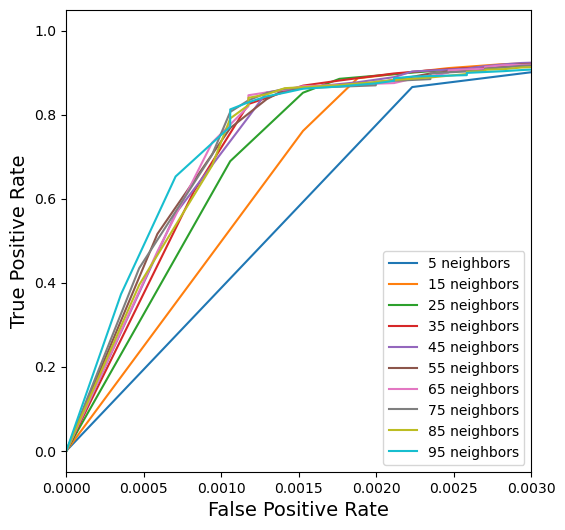

95 components gives the best performance.


In [112]:
def perform_knc_classification(train_data, train_labels, test_data, test_labels):
    # Define the range of neighbors for KNC classifier
    n = np.arange(5,101,10)
    
    # Preallocate lists to store false positive rates, true positive rates, and area under ROC curve
    fprs, tprs, area2 = [None]*len(n), [None]*len(n), [None]*len(n)
    
    # Loop over each number of neighbors
    for i, num_neighbors in enumerate(n):
        # Initialize and fit a KNC classifier with num_neighbors neighbors
        knc_classifier = KNeighborsClassifier(num_neighbors)
        knc_classifier.fit(train_data[:,:4], train_labels)

        # Predict the probabilities of each class for the test data
        y_prob = knc_classifier.predict_proba(test_data[:,:4])

        # Compute the ROC curve and area under the curve
        fprs[i], tprs[i], _ = roc_curve(test_labels, y_prob[:,1])
        area2[i] = roc_auc_score(test_labels, y_prob[:,1])

    # Create a plot to display the ROC curves
    fig, ax = plt.subplots(figsize=(6,6))

    # Loop over each set of false positive rates and true positive rates and plot them
    for j in range(len(n)):
        ax.plot(fprs[j], tprs[j], label=f'{n[j]} neighbors')
    ax.set_xlim(0,0.003)
    ax.set_xlabel('False Positive Rate',fontsize=14)
    ax.set_ylabel('True Positive Rate',fontsize=14)
    plt.legend()
    plt.show()

    # Return the list of areas under the ROC curves and the list of numbers of neighbors
    return area2 , n

def find_best_performance(area2, n):
    # Find the index of the maximum area under the ROC curve
    best_component = n[np.argmax(area2)]
    print(f'{best_component} components gives the best performance.')
    return best_component

# Call the function with your data to perform KNC classification and plot ROC curves
area2, n = perform_knc_classification(train_data, train_labels, test_data, test_labels)

# Call the function with the areas under the ROC curves to find the best performance
best_component = find_best_performance(area2, n)

part 8

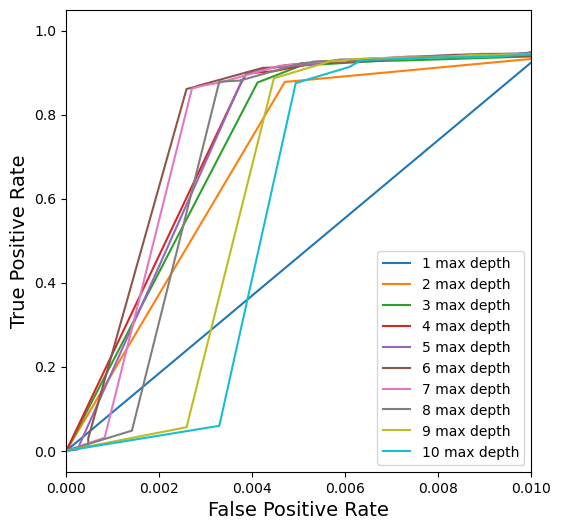

6 max tree depth gives the best performance.


In [113]:
def perform_dtree_classification(train_data, train_labels, test_data, test_labels):
    # Define the range of maximum depths for the Decision Tree classifier
    max_depths = np.arange(1, 11)
    
    # Preallocate lists to store false positive rates, true positive rates, and area under ROC curve
    fprs, tprs, area3 = [None]*len(max_depths), [None]*len(max_depths), [None]*len(max_depths)
    
    # Loop over each maximum depth
    for i, max_depth in enumerate(max_depths):
        # Initialize and fit a Decision Tree classifier with max_depth depth
        dtree_classifier = DecisionTreeClassifier(max_depth=max_depth)
        dtree_classifier.fit(train_data[:,:4], train_labels)

        # Predict the probabilities of each class for the test data
        y_prob = dtree_classifier.predict_proba(test_data[:,:4])

        # Compute the ROC curve and area under the curve
        fprs[i], tprs[i], _ = roc_curve(test_labels, y_prob[:,1])
        area3[i] = roc_auc_score(test_labels, y_prob[:,1])

    # Create a plot to display the ROC curves
    fig, ax = plt.subplots(figsize=(6,6))

    # Loop over each set of false positive rates and true positive rates and plot them
    for j in range(len(max_depths)):
        ax.plot(fprs[j], tprs[j], label=f'{max_depths[j]} max depth')
    ax.set_xlim(0,0.01)
    ax.set_xlabel('False Positive Rate',fontsize=14)
    ax.set_ylabel('True Positive Rate',fontsize=14)
    plt.legend()
    plt.show()

    # Return the list of areas under the ROC curves
    return area3

def find_best_performance(area3):
    # Find the index of the maximum area under the ROC curve
    best_component = np.argmax(area3) + 1
    print(f'{best_component} max tree depth gives the best performance.')
    return best_component

# Call the function with your data to perform Decision Tree classification and plot ROC curves
area3 = perform_dtree_classification(train_data, train_labels, test_data, test_labels)

# Call the function with the areas under the ROC curves to find the best performance
best_component = find_best_performance(area3)

part 9

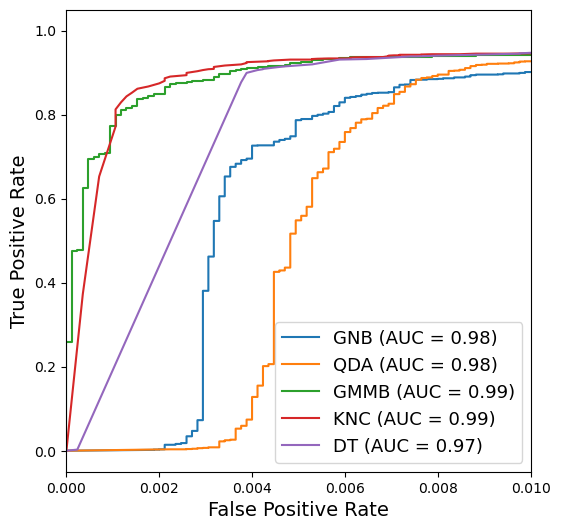

The best classifier is KNC with AUC = 0.99


In [106]:
def perform_all_classifications_and_compare(train_data, train_labels, test_data, test_labels):
    classifiers = {
        'GNB': GaussianNB(),
        'QDA': QDA(),
        'GMMB': GMMBayes(10),
        'KNC': KNeighborsClassifier(95),
        'DT': DecisionTreeClassifier(max_depth=5)
    }

    fig, ax = plt.subplots(figsize=(6,6))

    best_classifier = None
    best_auc = -1

    for name, classifier in classifiers.items():
        classifier.fit(train_data[:,:4], train_labels)
        y_prob = classifier.predict_proba(test_data[:,:4])
        fpr, tpr, _ = roc_curve(test_labels, y_prob[:,1])
        roc_auc = auc(fpr, tpr)
        if roc_auc > best_auc:
            best_auc = roc_auc
            best_classifier = name
        ax.plot(fpr, tpr,label=f'{name} (AUC = {roc_auc:.2f})')

    ax.set_xlim(0,0.01)
    ax.set_xlabel('False Positive Rate',fontsize=14)
    plt.ylabel('True Positive Rate',fontsize=14)
    plt.legend(fontsize=13)
    plt.show()

    print(f'The best classifier is {best_classifier} with AUC = {best_auc:.2f}')

# Call the function with your data
perform_all_classifications_and_compare(train_data, train_labels, test_data, test_labels)

part 10

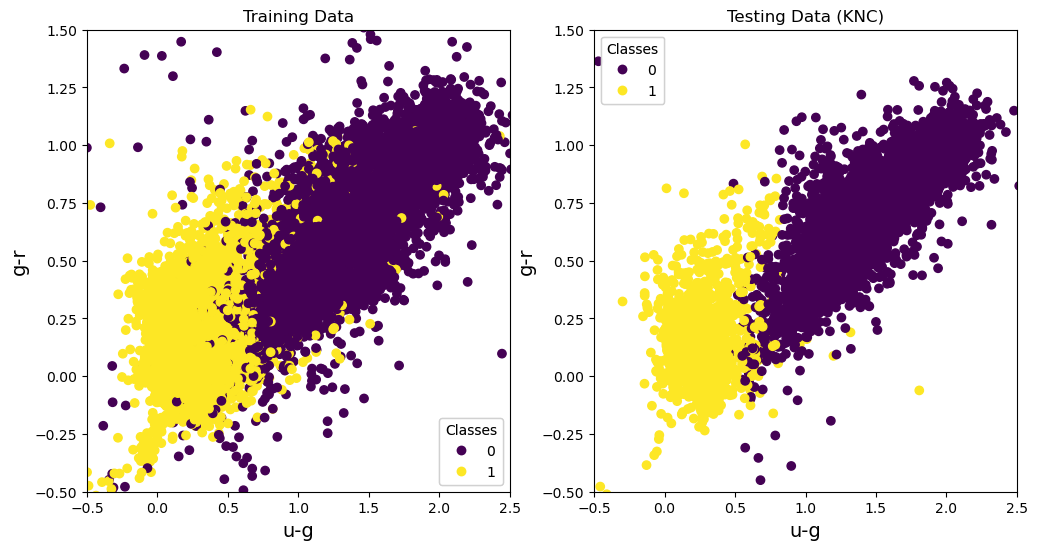

In [107]:
def plot_data_and_predictions(train_data, train_labels, test_data, test_labels, best_classifier):
    # Fit the best classifier to the training data and predict the classes for the testing data
    best_classifier.fit(train_data[:,:4], train_labels)
    y_pred = best_classifier.predict(test_data[:,:4])

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the training data in the left panel
    scatter = ax[0].scatter(train_data[:,0], train_data[:,1], c=train_labels)
    ax[0].set_xlabel('u-g', fontsize=14)
    ax[0].set_ylabel('g-r', fontsize=14)
    ax[0].set_title('Training Data')
    ax[0].set_xlim(-0.5,2.5); ax[0].set_ylim(-0.5,1.5)
    legend1 = ax[0].legend(*scatter.legend_elements(), title="Classes")
    ax[0].add_artist(legend1)

    # Plot the testing data in the right panel, color coded by their predicted class
    scatter = ax[1].scatter(test_data[:,0], test_data[:,1], c=y_pred)
    ax[1].set_xlabel('u-g', fontsize=14)
    ax[1].set_ylabel('g-r', fontsize=14)
    ax[1].set_title('Testing Data (KNC)')
    ax[1].set_xlim(-0.5,2.5); ax[1].set_ylim(-0.5,1.5)
    legend1 = ax[1].legend(*scatter.legend_elements(), title="Classes")
    ax[1].add_artist(legend1)

    plt.show()

# Call the function with your data and the best classifier
best_classifier = DecisionTreeClassifier(max_depth=5)
plot_data_and_predictions(train_data, train_labels, test_data, test_labels, best_classifier)

SRT: Terrific work, Kamara!! Perfect